In [1]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

from distributed import Client

import kwindy

## Goal: 

If we had offshore windfarms along the U.S. East Coast, would we have seen a change in energy production since 1940? 

#### Methods: 

*Step 1*: Single point analysis 
* First we'll take the windspeed values for a single grid cell in ERA5 and do some analysis. 
* Once we have a single point of offshore windspeeds, we'll fit the data with a weibull distribution for each decade of data. 
* Once we have the weibull distribution fits we can multiply the fit for each decade by an idealized power curve. Then you take the sum of those binned values and divide by the turbine rated power (kW) to get the net capacity factor (~56%).  Then to get the total energy output per year (GWh/year) you mulitply the net capacity factor (say 56%), the turbine rated power (kW), the number of turbines estimated per grid cell (31 km grid cell), and the number of hours per year (8766) and divide by (1000 *1000) to get the totaly energy output in GWh/year. 
* Then we'll have an estimated energy output per the given grid cell per decade and we can see if it changes in time or not. 

*Step 2:* Full Map 
* It would also be cool to do this for the whole map to see how things change across the US East Coast. 

In [5]:
client = Client(n_workers=4, threads_per_worker=2)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54242,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:54254,Total threads: 2
Dashboard: http://127.0.0.1:54260/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:54245,


In [2]:
full_era5_ds = kwindy.load_era5_from_cloud(desired_chunks='auto')

In [4]:
full_era5_ds

NameError: name 'full_era5_ds' is not defined

In [5]:
vars_of_interest = [
    "100m_u_component_of_wind", 
    "100m_v_component_of_wind", 
    "2m_temperature", 
    "significant_height_of_combined_wind_waves_and_swell", 
    "sea_surface_temperature",
    'air_density_over_the_oceans'
    ]

vars_to_drop = [var for var in list(full_era5_ds.data_vars) if var not in vars_of_interest]

In [16]:
era5_wind_ds = full_era5_ds.drop_vars(vars_to_drop)
era5_wind_ds = era5_wind_ds.drop_vars('level')
era5_wind_ds = era5_wind_ds.sel(time=slice('2014-01-01','2024-04-30'))

In [17]:
era5_USeast = era5_wind_ds.sel(longitude=slice(360-76,360-70),latitude=slice(41,35))
era5_USeast = era5_USeast.chunk({'time':'100M', 'latitude':'100M', 'longitude':'100M'})
era5_USeast

<xarray.Dataset> Size: 1GB
Dimensions:                                              (time: 90552,
                                                          latitude: 25,
                                                          longitude: 25)
Coordinates:
  * latitude                                             (latitude) float32 100B ...
  * longitude                                            (longitude) float32 100B ...
  * time                                                 (time) datetime64[ns] 724kB ...
Data variables:
    100m_u_component_of_wind                             (time, latitude, longitude) float32 226MB dask.array<chunksize=(40000, 25, 25), meta=np.ndarray>
    100m_v_component_of_wind                             (time, latitude, longitude) float32 226MB dask.array<chunksize=(40000, 25, 25), meta=np.ndarray>
    2m_temperature                                       (time, latitude, longitude) float32 226MB dask.array<chunksize=(40000, 25, 25), meta=np.ndarray>
    air_density_over_the_oceans                          (time, latitude, longitude) float32 226MB dask.array<chunksize=(40000, 25, 25), meta=np.ndarray>
    sea_surface_temperature                              (time, latitude, longitude) float32 226MB dask.array<chunksize=(40000, 25, 25), meta=np.ndarray>
    significant_height_of_combined_wind_waves_and_swell  (time, latitude, longitude) float32 226MB dask.array<chunksize=(40000, 25, 25), meta=np.ndarray>

In [19]:
windspeed = calc_windspeed(
    era5_USeast['100m_u_component_of_wind'],
    era5_USeast['100m_v_component_of_wind'],
    client
    )

In [26]:
windspeed.nbytes/1e9

0.22638

In [21]:
monmn_ws = windspeed.resample(time='M').mean()

/Users/katiebrennan/development/era5-analysis/.venv/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


In [23]:
plot_ws = monmn_ws.isel(latitude=0,longitude=0).values

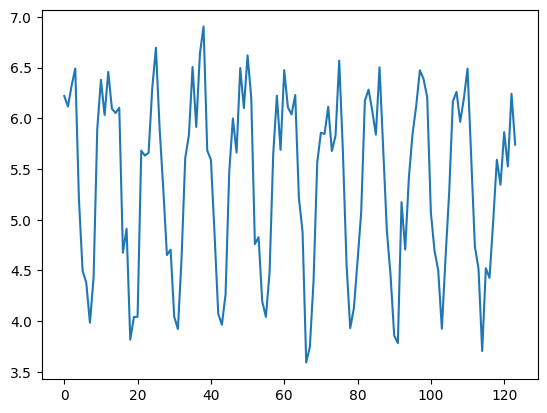

In [24]:
plt.plot(plot_ws)

Task exception was never retrieved
future: <Task finished name='Task-76394' coro=<Client._gather.<locals>.wait() done, defined at /Users/katiebrennan/development/era5-analysis/.venv/lib/python3.12/site-packages/distributed/client.py:2391> exception=AllExit()>
Traceback (most recent call last):
  File "/Users/katiebrennan/development/era5-analysis/.venv/lib/python3.12/site-packages/distributed/client.py", line 2400, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

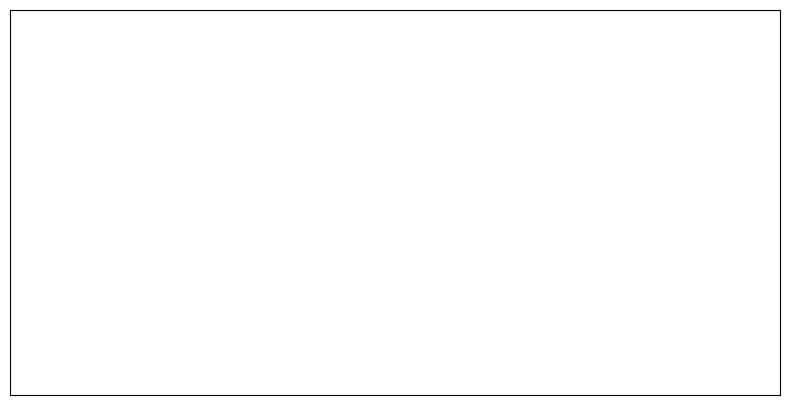

In [8]:
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

plot_var = era5_USeast.isel(time=0).significant_height_of_combined_wind_waves_and_swell
plot_var.plot(
    ax=ax, transform=ccrs.PlateCarree(), cmap='PuBu',add_colorbar=True
    )
plt.scatter(era5_USeast.longitude.values[10],era5_USeast.latitude.values[10], color='r')

ax.set_title('ERA5: Significant Wave Height')
ax.coastlines()

### Select a single point to calculate weibull fit: 

In [9]:
era5_single_point = era5_USeast.isel(latitude=10, longitude=10)
# era5_single_point = era5_single_point.chunk({'time':388608})

In [10]:
era5_single_point

<xarray.Dataset> Size: 12MB
Dimensions:                                              (time: 388608)
Coordinates:
    latitude                                             float32 4B 38.5
    longitude                                            float32 4B 286.5
  * time                                                 (time) datetime64[ns] 3MB ...
Data variables:
    100m_u_component_of_wind                             (time) float32 2MB dask.array<chunksize=(40000,), meta=np.ndarray>
    100m_v_component_of_wind                             (time) float32 2MB dask.array<chunksize=(40000,), meta=np.ndarray>
    2m_temperature                                       (time) float32 2MB dask.array<chunksize=(40000,), meta=np.ndarray>
    air_density_over_the_oceans                          (time) float32 2MB dask.array<chunksize=(40000,), meta=np.ndarray>
    sea_surface_temperature                              (time) float32 2MB dask.array<chunksize=(40000,), meta=np.ndarray>
    significant_height_of_combined_wind_waves_and_swell  (time) float32 2MB dask.array<chunksize=(40000,), meta=np.ndarray>

In [11]:
windspeed = calc_windspeed(
    era5_single_point['100m_u_component_of_wind'],
    era5_single_point['100m_v_component_of_wind'],
    client
    )

In [15]:
windspeed.resample(time="M").mean().plot()

/Users/katiebrennan/development/era5-analysis/.venv/lib/python3.12/site-packages/xarray/core/groupby.py:668: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


KeyboardInterrupt: 